In [1]:
## imports
import pickle

import numpy as np
import pandas as pd
import openml
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import (

    StratifiedKFold,  # use X = np.zeros(n_samples) in .split
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import data_tab
from btv import *

# from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors

# if you have indeces and want knns from large set, can make an idx array and NearestVectorCaller._call_vec_set; can just train/test split np.arange(len(ds)) to get back indeces for large sets

In [34]:
electric_ds = data_tab.getdata(44156)
electric_df, X, y = data_tab.dataset2df(electric_ds, ["class"]) 
# should prolly use some time series model for this...

OpenML Dataset
Name..........: electricity
Version.......: 13
Format........: arff
Upload Date...: 2022-07-10 10:34:54
Licence.......: Public
Download URL..: https://api.openml.org/data/v1/download/22103281/electricity.arff
OpenML URL....: https://www.openml.org/d/44156
# of features.: 9
# of instances: 38474


In [2]:
iris_ds = data_tab.getdata(61)
iris_df, X, y = data_tab.dataset2df(iris_ds,'class')

OpenML Dataset
Name..........: iris
Version.......: 1
Format........: ARFF
Upload Date...: 2014-04-06 23:23:39
Licence.......: Public
Download URL..: https://api.openml.org/data/v1/download/61/iris.arff
OpenML URL....: https://www.openml.org/d/61
# of features.: 5
# of instances: 150


In [35]:
## Data setup
electric_ds = openml.datasets.get_dataset(dataset_id=44156)
electric_df, *_ = electric_ds.get_data()
print(electric_ds)
X = electric_df.loc[:, [x != "class" for x in electric_df.columns]]
y = electric_df.loc[:, "class"]
le = LabelEncoder()
y = le.fit_transform(y)
print(sum(y) / len(y))  # fraction of "UP" periods

OpenML Dataset
Name..........: electricity
Version.......: 13
Format........: arff
Upload Date...: 2022-07-10 10:34:54
Licence.......: Public
Download URL..: https://api.openml.org/data/v1/download/22103281/electricity.arff
OpenML URL....: https://www.openml.org/d/44156
# of features.: 9
# of instances: 38474
0.5


In [38]:
ds = data_tab.getdata(44156)
df, X, y = data_tab.dataset2df(ds, class_cols=['class'])

OpenML Dataset
Name..........: electricity
Version.......: 13
Format........: arff
Upload Date...: 2022-07-10 10:34:54
Licence.......: Public
Download URL..: https://api.openml.org/data/v1/download/22103281/electricity.arff
OpenML URL....: https://www.openml.org/d/44156
# of features.: 9
# of instances: 38474


In [9]:
np.unique(y[test_idx], return_counts=True)
# what to do about very imbalaced sets?
# re-do label encoder every time? It's not gradient decent so the weights are not improved iteratevly, 
#    the daata is curated itaratively...
# make a copy of the classifyer to do the scoring?
# TODO: make single-label info calulator

(array([ 3,  6,  8,  9, 13, 14, 20, 23, 28]),
 array([ 1,  1,  1,  1, 15,  1,  1,  1,  1]))

In [3]:
clf_knn = fit_dknn_toXy(X,y)

In [5]:
## Model setup
from sklearn.ensemble import GradientBoostingClassifier

## could do a little metaparameter search
clf = GradientBoostingClassifier(
    n_estimators=100, learning_rate=1.0, max_depth=1, random_state=10
)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

0.8187134502923976

In [37]:
clf.predict_proba(X.iloc[test_idx]).shape

(23, 32)

In [ ]:
## with straigh vectorization of whole images, the knn accuracy goes down as more data is added. Therefore that vecotrization is shit. Maybe we try tabular data?

kfold_idx_gen = StratifiedKFold(n_splits=100).split(X, y)
train_idx = np.array([], int)
running_train, entropies, train_idx = [], [], []
for k, (_, test_idx) in enumerate(kfold_idx_gen):
    running_train.append(test_idx)
running_test = running_train.pop()

if len(np.unique(running_test)) < len(np.unique(y)):
    print("Low class!")
    reresentatives = np.array([])
    for y_val in np.unique(y):
        reresentatives =  np.append(reresentatives,np.where(y==y_val)[0][0])
    running_train[0] = np.unique(np.append(running_train[0], reresentatives)).astype(int)
    
for k, old_test_idx in enumerate(running_train):
    train_idx = np.append(train_idx, old_test_idx).astype(int)
    clf.fit(X.iloc[train_idx], y[train_idx])
    y_predicted = clf.predict_proba(X.iloc[running_test])
    y_true = y[running_test]
    H = prediction_entropy(y_true, y_predicted)
    entropies.append(H)
    print(
        f"Fold : {k+1}, " f"Test set entropy : {np.mean(H)}",
        f"Train samples : {len(train_idx)}",
        f"Accuracy : {accuracy_score(y_true,clf.predict(X.iloc[test_idx]))}",
    )

In [6]:
## add_best_fold_first_test
n_splits = 100
verbose = True

kfold_idx_gen = StratifiedKFold(n_splits=5).split(X, y)
train_idx = np.array([], int)
running_train, entropies, train_idx, scores, samples = [], [], [], [], []
for k, (_, test_idx) in enumerate(kfold_idx_gen):
    running_train.append(test_idx)
running_test = running_train.pop()
running_train = order_folds_by_entropy(X, y, clf, running_train)

for k, old_test_idx in enumerate(running_train):
    train_idx = np.append(train_idx, old_test_idx).astype(int)
    clf.fit(X.iloc[train_idx], y[train_idx])
    y_predicted = clf.predict_proba(X.iloc[running_test])
    y_true = y[running_test]
    H = prediction_entropy(y_true, y_predicted)
    score = clf.score(X.iloc[test_idx], y_true)
    entropies.append(H)
    scores.append(score)
    samples.append(len(train_idx))
    if verbose:
        print(
            f"Fold : {k+1}, " f"Test set entropy : {np.mean(H)}",
            f"Train samples : {len(train_idx)}",
            f"Score : {score}",
        )

Fold : 1, Test set entropy : 0.0 Train samples : 7695 Score : 0.5365219651676632
Fold : 2, Test set entropy : 0.0 Train samples : 15390 Score : 0.4902521445282038
Fold : 3, Test set entropy : 0.0 Train samples : 23085 Score : 0.49155185859110995
Fold : 4, Test set entropy : 0.0 Train samples : 30780 Score : 0.5055887704704964


In [4]:
samples, hs0, ss0 = add_stratified_folds_test(X, y, clf, 100, verbose=False)

In [ ]:
plt.plot(samples, hs0, label="Entropy")
ax1 = plt.gca()
ax1.set_ylabel("Entropy [bits]")

ax2 = ax1.twinx()
ax2.plot(samples, ss0, color="g", label="Score")
ax2.set_ylabel("Accuracy")

In [29]:
samples, hs1, ss1 = add_best_fold_first_test(X, y, clf, 100, verbose=False)

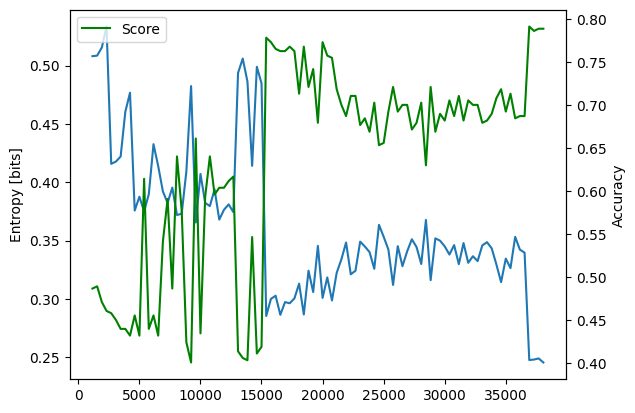

In [30]:
plt.plot(samples[2:], hs1[2:], label="Entropy")
ax1 = plt.gca()
ax1.set_ylabel("Entropy [bits]")

ax2 = ax1.twinx()
ax2.plot(samples[2:], ss1[2:], color="g", label="Score")
ax2.set_ylabel("Accuracy")

plt.legend()

In [35]:
# cutting data finer gets to the relavent data faster
samples, hs2, ss2 = add_best_fold_first_test(X_train, y_train, clf_nn, 100, verbose=False)

Text(0.5, 1.0, 'With NN classifier')

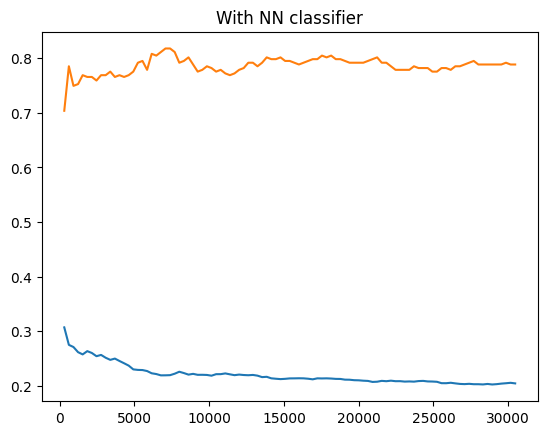

In [36]:
plt.plot(samples, hs2)
plt.plot(samples, ss2)
plt.title('With NN classifier')

In [4]:
## standard train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

NameError: name 'clf' is not defined

In [ ]:
# Can match/beat standard performance on less data (however it is slower)
samples, entropies, scores, best_idxs = train_best_fold_first_test(
    X_train, y_train, clf_nn, 190, tol=20
)
print(np.max(scores))
print(clf.score(X_test,y_test))
# clf.fit(X_train, y_train)
# print(clf.score(X_test,y_test))

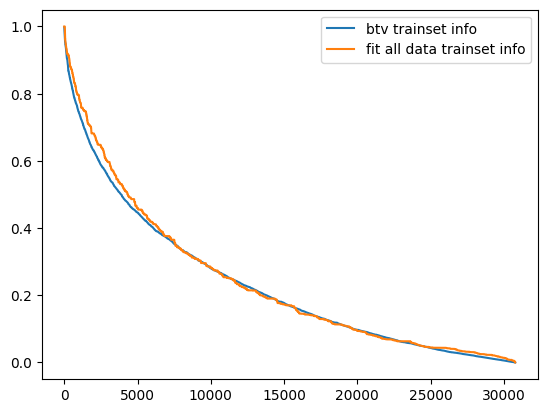

In [44]:
# kfold_idx_gen = StratifiedKFold(n_splits=100).split(X, y)
# train_idx = np.array([], int)
# running_train, entropies, train_idx = [], [], []
# for k, (_, test_idx) in enumerate(kfold_idx_gen):
#     running_train.append(test_idx)
# idx0 = running_train.pop(0)
# clf.fit(X.iloc[idx0], y[idx0])
sorted_X, sorted_y, info = order_samples_by_info(X_train, y_train,clf)
clf.fit(X_train, y_train)
print(clf.score(X_test,y_test))
sorted_X, sorted_y, info2 = order_samples_by_info(X_train, y_train,clf)
plt.plot(sorted(info, reverse=True), label='btv trainset info')
plt.plot(sorted(info2, reverse=True), label='fit all data trainset info')
plt.legend()

In [ ]:
# Back to sufficiency of fine-tuning set...

In [53]:
sum(info2) - sum(info) #diff left in training data

227.70383869678972

In [59]:
1831-1784

47

In [14]:
tiny_x = np.vstack([X[:6],X[-6:]])
tiny_y = np.append(y[:6],y[-6:])
clf.fit(tiny_x,tiny_y)
print('minimal fit train info: ', np.sum(prediction_info(y_train,clf.predict_proba(X_train))), 'bits') 
print('minimal fit test info: ', np.sum(prediction_info(y_test,clf.predict_proba(X_test))), 'bits') 
# print('classifyer size: ', sys.getsizeof(clf) * 8, 'bits')

minimal fit train info:  15408.599221244542 bits
minimal fit test info:  3891.8986828039847 bits


In [17]:
samples, entropies, scores, best_idxs = train_best_fold_first_test(
    X_train, y_train, clf_nn, 100, tol=20
)
print(clf.score(X_test,y_test))
print('Best first test H: ', prediction_entropy(y_test,clf.predict_proba(X_test)))
print('Best first test info: ', np.sum(prediction_info(y_test,clf.predict_proba(X_test)))) #btv fit test info
print('Best first train H: ', prediction_entropy(y_train[best_idxs],clf.predict_proba(X_train[best_idxs]))) #btv fit train info
print('Best first train info: ', np.sum(prediction_info(y_train[best_idxs],clf.predict_proba(X_train[best_idxs])))) 

 43%|███████████████████████████▎                                   | 43/99 [00:13<00:17,  3.13it/s]

No improvement found after adding 20 folds (6156 samples). Fitting on 23 folds, 7387 smaples.
0.49421702404158546
Best first test H:  0.505769809331252
Best first test info:  3891.8986828039847
Best first train H:  0.5019498191234031
Best first train info:  3707.903313864578


In [30]:
clf.fit(X_train, y_train)
print(clf.score(X_test,y_test))
print('Fit all test H: ', prediction_entropy(y_test,clf.predict_proba(X_test))) #fit all test info
print('Fit all test info: ', np.sum(prediction_info(y_test,clf.predict_proba(X_test)))) 
print('Fit all train H: ', prediction_entropy(y_train,clf.predict_proba(X_train))) #fit all test info
print('Fit all train info: ', np.sum(prediction_info(y_train,clf.predict_proba(X_train)))) #fit all test info

0.816114359974009
Fit all test H:  0.05761300914918303
Fit all test info:  443.3321054029634
Fit all train H:  0.05702021947355081
Fit all train info:  1755.0253351764202


In [153]:
np.sum(prediction_info(y_train,clf.predict_proba(X_train)))/len(y_train)

0.22017847997549345

In [165]:
6776.873435165713 * 2

13553.746870331426

In [ ]:
# can use a classifyer to tell which 

(X_train,y_train,X_test,y_test,best_idxs) = pickle.load(open('show relative info goes as performance.pkl','rb'))
tiny_x = pd.concat([X.iloc[:6],X.iloc[-6:]])
tiny_y = np.append(y[:6],y[-6:])
clf_nn.fit(tiny_x,tiny_y)
clf.fit(tiny_x,tiny_y)

#actually sucks that info is model-dependant, but the knn selects a set that is MORE informative than the total FORE THE RF
print(cal_info_about(X_train,y_train, X_test, y_test, clf_nn) - cal_info_about(X_train.iloc[best_idxs],y_train[best_idxs], X_test, y_test, clf_nn))
print(cal_info_about(X_train,y_train, X_test, y_test, clf) - cal_info_about(X_train.iloc[best_idxs],y_train[best_idxs], X_test, y_test, clf))


In [ ]:
tiny_x = np.vstack([X[:6],X[-6:]])
tiny_y = np.append(y[:6],y[-6:])
clf.fit(tiny_x,tiny_y)
print('minimal fit train info: ', np.sum(prediction_info(y_train,clf.predict_proba(X_train))), 'bits') # many bits in total train set
print('minimal fit test info: ', np.sum(prediction_info(y_test,clf.predict_proba(X_test))), 'bits')  # 3558 bits of ignorance in test set before training
print('Best first train info: ', np.sum(prediction_info(y_train[best_idxs],clf.predict_proba(X_train[best_idxs]))), 'bits') # 2024 bits in selected training set
clf.fit(X_train[best_idxs], y_train[best_idxs])
print('Best fit test info: ', np.sum(prediction_info(y_test,clf.predict_proba(X_test)))), 'bits')  # bits of ignorance in test set after training
# print('classifyer size: ', sys.getsizeof(clf) * 8, 'bits')

In [203]:
## Lets try using the test set to pick the training set
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

clf_knn = fit_dknn_toXy(X_train, y_train)
full_train_test_info = np.sum(prediction_info(y_test, clf_knn.predict_proba(X_test)))
print(full_train_test_info)
print(clf_knn.score(X_test,y_test))
clf_knn.fit(X_test,y_test)
sorted_X, sorted_y, info = order_samples_by_info(X_train,y_train,clf_knn, sort_info=True)
max_idx = np.where(np.cumsum(info) < full_train_test_info)[0]
clf_knn.fit(sorted_X[:max_idx,:],sorted_y[:max_idx])
print(max_idx)
print(np.sum(prediction_info(y_test, clf_knn.predict_proba(X_test))))
print(clf_knn.score(X_test,y_test))

0.17912185937997097
1.0


TypeError: only integer scalar arrays can be converted to a scalar index

In [204]:
nn = NearestNeighbors(n_neighbors=1, metric="euclidean").fit(X_train)
_, train0_idxs = nn.kneighbors(X_test)
train0_idxs = train0_idxs.squeeze()
clf_knn.fit(X_train[train0_idxs], y_train[train0_idxs])
print(np.sum(prediction_info(y_test, clf_knn.predict_proba(X_test))))
print(clf_knn.score(X_test,y_test))
clf.fit(X_train[train0_idxs], y_train[train0_idxs])
print(np.sum(prediction_info(y_test, clf.predict_proba(X_test))))
print(clf.score(X_test,y_test))

1.3018266873886875
0.9333333333333333
1.9999999404173145
0.9666666666666667


In [54]:
## using only the train set and the total info in test set, we down-select the training set
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2) #, random_state=22)
info_thresh = 0.1

tiny_x = np.vstack([X_train[:6],X_train[-6:]])
tiny_y = np.append(y_train[:6],y_train[-6:])
clf_knn = fit_dknn_toXy(tiny_x, tiny_y)
min_train_test_info_residual = np.sum(prediction_info(y_test, clf_knn.predict_proba(X_test)))
full_train_test_info = cal_info_about_test_set_in_train_set(X_train,y_train, X_test, y_test, clf_knn)
clf_knn.fit(X_train, y_train)
full_train_test_info_residual = np.sum(prediction_info(y_test, clf_knn.predict_proba(X_test)))
print("full train set size: ", y_train.size)
print("min_train_test_info_residual: ", min_train_test_info_residual)
print("full_train_test_info: ", full_train_test_info)
print("full_train_test_info_residual: ",full_train_test_info_residual)
print("full train score: ", clf_knn.score(X_test,y_test))

clf_knn_selfdrop = KNeighborsClassifier(n_neighbors=100, metric='euclidean', weights=dist_weight_ignore_self)
clf_knn_selfdrop.fit(X_train, y_train)
train_self_info = np.sum(prediction_info(y_test, clf_knn_selfdrop.predict_proba(X_train)))
print("Train set self-info:", train_self_info)

sorted_X, sorted_y, info = order_samples_by_info(X_train,y_train,clf_knn_selfdrop, sort_info=False)
tiny_x = np.vstack([X_train[:6],X_train[-6:]])
tiny_y = np.append(y_train[:6],y_train[-6:])
clf_knn.fit(tiny_x, tiny_y)
self_pruned_train_test_info =  cal_info_about_test_set_in_train_set(X_train[info>info_thresh],y_train[info>info_thresh], X_test, y_test, clf_knn)
print("Self-pruned train set size: ", y_train[info>info_thresh].size)
print("self_pruned_train_test_info: ", self_pruned_train_test_info)
clf_knn.fit(X_train[info>info_thresh,:],y_train[info>info_thresh])
self_pruned_train_test_info_residual = np.sum(prediction_info(y_test, clf_knn.predict_proba(X_test)))
print("self_pruned_train_test_info_residual: ", self_pruned_train_test_info_residual)
print("self_pruned_score: ", clf_knn.score(X_test,y_test))
rand_idx = np.random.choice(np.arange(len(X_train)),y_train[info>info_thresh].size)
clf_knn.fit(X_train[rand_idx,:],y_train[rand_idx])
print("random pruning baseline:", clf_knn.score(X_test,y_test))

full train set size:  30779
min_train_test_info_residual:  286.60309409113677
full_train_test_info:  -196.58588697641494
full_train_test_info_residual:  483.1889810675517
full train score:  0.8105263157894737
Train set self-info: 1819.607858949349
Self-pruned train set size:  4595
self_pruned_train_test_info:  -284.4816710310994
self_pruned_train_test_info_residual:  571.0847651222361
self_pruned_score:  0.7738791423001949
random pruning baseline: 0.7562053281351527


In [55]:
#still works for another kind of classifier doing the final fit
clf.fit(X_train, y_train)
print(clf.score(X_test,y_test))
clf.fit(X_train[info>0,:],y_train[info>0])
print(clf.score(X_test,y_test))
clf.fit(X_train[rand_idx,:],y_train[rand_idx])
print(clf.score(X_test,y_test))

0.8187134502923976
0.8103963612735543
0.8064977257959715


In [196]:
clf.fit(X_train, y_train)
np.sum(prediction_info(y_test, clf.predict_proba(X_test)))

1.4526641969093668

In [198]:
nn = NearestNeighbors(n_neighbors=1, metric="euclidean").fit(X_train)
_, train0_idxs = nn.kneighbors(X_test)
train0_idxs = train0_idxs.squeeze()
clf_knn.fit(X_train[train0_idxs],y_train[train0_idxs])
print(np.sum(prediction_info(y_test, clf_knn.predict_proba(X_test))))
print(clf_knn.score(X_test,y_test))
sorted_X, sorted_y, info = order_samples_by_info(X_train[train0_idxs],y_train[train0_idxs],clf_knn)
clf_knn.fit(X_train[train0_idxs][info>0],y_train[train0_idxs][info>0])
print(np.sum(prediction_info(y_test, clf_knn.predict_proba(X_test))))
print(clf_knn.score(X_test,y_test))

1.3018266873886875
0.9333333333333333


ValueError: Found array with 0 sample(s) (shape=(0, 4)) while a minimum of 1 is required by KNeighborsClassifier.